In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import os

matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [2]:
random_sample_size = 1_000_000
bin_multiplier = 100 # how many bins to use (assuming the range is [0, 1], double for the range [-1, 1])

In [ ]:
ml_df = pd.read_csv('../datasets/movie_lens/ratings.csv.gz')
max_user_id = ml_df['user_id'].max()
max_item_id = ml_df['item_id'].max()
print(max_user_id)
print(max_item_id)

In [ ]:
from scipy.sparse import lil_matrix

max_user_id = ml_df['user_id'].max()
max_item_id = ml_df['item_id'].max()

users_to_items_ratings = lil_matrix((max_user_id + 1, max_item_id + 1), dtype=np.float32)
progress = tqdm(total=len(ml_df))
for user_id, item_id, rating, _ in ml_df.itertuples(index=False):
    users_to_items_ratings[user_id, item_id] = rating
    progress.update(1)
progress.close()

In [ ]:
# # iteratively calculate histogram of similarity between users
# from scipy.stats import pearsonr
# from scipy.spatial.distance import jaccard, cosine
# from collections import defaultdict

# counts_pearson = defaultdict(int)
# counts_jaccard = defaultdict(int)
# counts_cosine = defaultdict(int)

# users = ml_df['user_id'].unique()
# random_sample_size = 100
# bin_multiplier = 100
# users_random_sample = np.random.choice(users, random_sample_size, replace=False)

# counter = tqdm(total=(len(users_random_sample) ** 2 / 2 ))
# for user_id in users_random_sample:
#     for other_user_id in users_random_sample:
#         if user_id <= other_user_id:
#             continue
#         user_ratings = users_to_items_ratings[user_id, :].toarray().flatten()
#         other_user_ratings = users_to_items_ratings[other_user_id, :].toarray().flatten()

#         peaerson_similarity, p_value = pearsonr(user_ratings, other_user_ratings)
#         peaerson_similarity_bin = int(peaerson_similarity * bin_multiplier)
#         counts_pearson[peaerson_similarity_bin] += 1

#         user_ratings_bool = user_ratings > 0
#         other_user_ratings_bool = other_user_ratings > 0
#         jaccard_similarity = np.logical_and(user_ratings_bool, other_user_ratings_bool).sum() / np.logical_or(user_ratings_bool, other_user_ratings_bool).sum()
#         jaccard_similarity_bin = int(jaccard_similarity * bin_multiplier)
#         counts_jaccard[jaccard_similarity_bin] += 1


#         cosine_similarity = cosine(user_ratings, other_user_ratings)
#         cosine_similarity_bin = int(cosine_similarity * bin_multiplier)
#         counts_cosine[cosine_similarity_bin] += 1

#         counter.update(1)
# counter.close()

In [ ]:
# iteratively calculate histogram of similarity between users
from scipy.stats import pearsonr
from scipy.spatial.distance import jaccard, cosine
from collections import defaultdict
import random

counts_pearson = defaultdict(int)
counts_jaccard = defaultdict(int)
counts_cosine = defaultdict(int)

append_exact = True

pearson_exact = list()
jaccard_exact = list()
cosine_exact = list()

num_unique_users = users_to_items_ratings.shape[0]

def get_random_users(max):
    while True:
        u1, u2 = random.randint(0, max), random.randint(0, max)
        if u1 != u2:
            return u1, u2

users = ml_df['user_id'].unique()

counter = tqdm(total=random_sample_size)
for _ in range(random_sample_size):
    u1, u2 = get_random_users(num_unique_users - 1)

    user_ratings = users_to_items_ratings[u1, :].toarray().flatten()
    other_user_ratings = users_to_items_ratings[u2, :].toarray().flatten()

    peaerson_similarity, p_value = pearsonr(user_ratings, other_user_ratings)
    peaerson_similarity_bin = int(peaerson_similarity * bin_multiplier)
    counts_pearson[peaerson_similarity_bin] += 1
    if append_exact:
        pearson_exact.append(peaerson_similarity)

    user_ratings_bool = user_ratings > 0
    other_user_ratings_bool = other_user_ratings > 0
    jaccard_similarity = np.logical_and(user_ratings_bool, other_user_ratings_bool).sum() / np.logical_or(user_ratings_bool, other_user_ratings_bool).sum()
    jaccard_similarity_bin = int(jaccard_similarity * bin_multiplier)
    counts_jaccard[jaccard_similarity_bin] += 1
    if append_exact:
        jaccard_exact.append(jaccard_similarity)

    cosine_similarity = cosine(user_ratings, other_user_ratings)
    cosine_similarity_bin = int(cosine_similarity * bin_multiplier)
    counts_cosine[cosine_similarity_bin] += 1
    if append_exact:
        cosine_exact.append(cosine_similarity)

    counter.update(1)
counter.close()

In [ ]:

counts_pearsons_df = pd.DataFrame.from_dict(counts_pearson, orient='index', columns=['count'])
counts_pearsons_df.reset_index(inplace=True)
counts_pearsons_df.rename(columns={'index': 'bin_orig'}, inplace=True)
counts_pearsons_df['bin'] = counts_pearsons_df.bin_orig.astype(float) / 100
counts_pearsons_df.sort_values(by='bin', inplace=True)
# add cumulative sum of counts
counts_pearsons_df['cum_count'] = counts_pearsons_df['count'].cumsum()
counts_pearsons_df['cum_count_norm'] = counts_pearsons_df['cum_count'] / random_sample_size

# inverse of bins
counts_pearsons_df['bin_inv'] = 1 - counts_pearsons_df['bin']

if append_exact:
    pearson_exact_df = pd.DataFrame(pearson_exact)
    pearson_exact_df.columns = ['similarity']

print(counts_pearsons_df)

In [ ]:
counts_jaccards_df = pd.DataFrame.from_dict(counts_jaccard, orient='index', columns=['count'])
counts_jaccards_df.reset_index(inplace=True)
counts_jaccards_df.rename(columns={'index': 'bin_orig'}, inplace=True)
counts_jaccards_df['bin'] = counts_jaccards_df.bin_orig.astype(float) / 100
counts_jaccards_df['bin_inv'] = 1 - counts_pearsons_df['bin']
counts_jaccards_df.sort_values(by='bin', inplace=True)
# add cumulative sum of counts
counts_jaccards_df['cum_count'] = counts_jaccards_df['count'].cumsum()
counts_jaccards_df['cum_count_norm'] = counts_jaccards_df['cum_count'] / random_sample_size
# inverse of bins
counts_jaccards_df['bin_inv'] = 1 - counts_jaccards_df['bin']

if append_exact:
    jaccard_exact_df = pd.DataFrame(jaccard_exact)
    jaccard_exact_df.columns = ['similarity']

print(counts_jaccards_df)

In [ ]:

counts_cosine_df = pd.DataFrame.from_dict(counts_cosine, orient='index', columns=['count'])
counts_cosine_df.reset_index(inplace=True)
counts_cosine_df.rename(columns={'index': 'bin_orig'}, inplace=True)
counts_cosine_df['bin'] = counts_cosine_df.bin_orig.astype(float) / 100
counts_cosine_df['bin_inv'] = 1 - counts_cosine_df['bin']
counts_cosine_df.sort_values(by='bin_inv', inplace=True)
# add cumulative sum of counts
counts_cosine_df['cum_count'] = counts_cosine_df['count'].cumsum()
counts_cosine_df['cum_count_norm'] = counts_cosine_df['cum_count'] / random_sample_size

if append_exact:
    cosine_exact_df = pd.DataFrame(cosine_exact)
    cosine_exact_df.columns = ['similarity']

# inverse of bins
print(counts_cosine_df)

In [ ]:
# create directory dfs if not exits
if not os.path.exists('dfs'):
    os.makedirs('dfs')
# save the dataframes to files
counts_pearsons_df.to_csv('dfs/counts_pearsons_df.csv', index=False)
counts_jaccards_df.to_csv('dfs/counts_jaccards_df.csv', index=False)
counts_cosine_df.to_csv('dfs/counts_cosine_df.csv', index=False)
if append_exact:
    pearson_exact_df.to_csv('dfs/pearson_exact_df.csv', index=False)
    jaccard_exact_df.to_csv('dfs/jaccard_exact_df.csv', index=False)
    cosine_exact_df.to_csv('dfs/cosine_exact_df.csv', index=False)


In [3]:
# load dataframes if not exist
# check if counts_pearsons_df variable exist
counts_pearsons_df = pd.read_csv('dfs/counts_pearsons_df.csv')
counts_jaccards_df = pd.read_csv('dfs/counts_jaccards_df.csv')
counts_cosine_df = pd.read_csv('dfs/counts_cosine_df.csv')

load_exact = True

if load_exact:
    pearson_exact_df = pd.read_csv('dfs/pearson_exact_df.csv')
    jaccard_exact_df = pd.read_csv('dfs/jaccard_exact_df.csv')
    cosine_exact_df = pd.read_csv('dfs/cosine_exact_df.csv')


In [4]:
counts_pearsons_df.dtypes

bin_orig            int64
count               int64
bin               float64
cum_count           int64
cum_count_norm    float64
bin_inv           float64
dtype: object

In [5]:
counts_pearsons_df

,bin_orig,count,bin,cum_count,cum_count_norm,bin_inv
0,-1,1,-0.01,1,0.000001,1.01
1,0,137214,0.00,137215,0.137215,1.00
2,1,44912,0.01,182127,0.182127,0.99
3,2,57739,0.02,239866,0.239866,0.98
4,3,59660,0.03,299526,0.299526,0.97
...,...,...,...,...,...,...
80,79,2,0.79,999988,0.999988,0.21
81,80,5,0.80,999993,0.999993,0.20
82,81,4,0.81,999997,0.999997,0.19
83,85,2,0.85,999999,0.999999,0.15


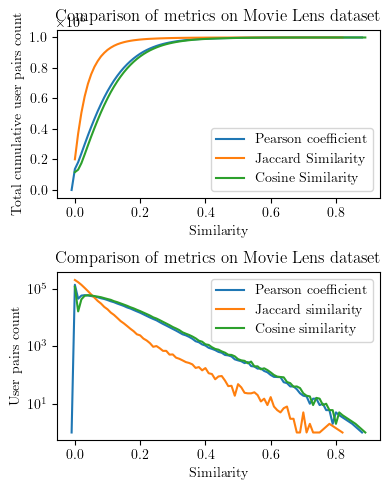

In [6]:
# plot graph and cumulative sum of counts
fig, axs = plt.subplots(2, 1, figsize=(4, 5), dpi=100)
# set contrasting colors for the two plots
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
sns.lineplot(x='bin', y='cum_count', ax=axs[0], data=counts_pearsons_df, label='Pearson coefficient', color=colors[0])
sns.lineplot(x='bin', y='cum_count', ax=axs[0], data=counts_jaccards_df, label='Jaccard Similarity', color=colors[1])
sns.lineplot(x='bin_inv', y='cum_count', ax=axs[0], data=counts_cosine_df, label='Cosine Similarity', color=colors[2])

# axs[0].set_yscale('log')
axs[0].legend()
axs[0].set_xlabel('Similarity')
axs[0].set_ylabel('Total cumulative user pairs count')
axs[0].set_title(f"Comparison of metrics on Movie Lens dataset")

sns.lineplot(x='bin', y='count', ax=axs[1], data=counts_pearsons_df, label='Pearson coefficient', color=colors[0])
sns.lineplot(x='bin', y='count', ax=axs[1], data=counts_jaccards_df, label='Jaccard similarity', color=colors[1])
sns.lineplot(x='bin_inv', y='count', ax=axs[1], data=counts_cosine_df, label='Cosine similarity', color=colors[2])

# set y-axis to log scale
axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_xlabel('Similarity')
axs[1].set_ylabel('User pairs count')
axs[1].set_title(f"Comparison of metrics on Movie Lens dataset")

# tight
plt.tight_layout()
plt.savefig('../figures/similarity_metrics.pdf')
plt.show()

In [25]:
# histogram for counts for 10 bins of 0.1 size
# group by bin and count
counts_cosine_df['bin_group'] = counts_cosine_df['bin_inv'].apply(lambda x: int(x * 10))
counts_cosine_df_grouped = counts_cosine_df.groupby('bin_group')['count'].sum().reset_index()
counts_cosine_df_grouped['bin'] = counts_cosine_df_grouped['bin_group'] / 10
counts_cosine_df_grouped.sort_values(by='bin', inplace=True)
counts_cosine_df_grouped.drop(columns=['bin_group'], inplace=True)
counts_cosine_df_grouped['cumulative_count'] = counts_cosine_df_grouped['count'].cumsum()
counts_cosine_df_grouped['cumulative_count_norm'] = counts_cosine_df_grouped['cumulative_count'] / random_sample_size
print(counts_cosine_df_grouped)


    count  bin  cumulative_count  cumulative_count_norm
0  600716  0.0            600716               0.600716
1  275099  0.1            875815               0.875815
2   85691  0.2            961506               0.961506
3   27761  0.3            989267               0.989267
4    7472  0.4            996739               0.996739
5    2414  0.5            999153               0.999153
6     702  0.6            999855               0.999855
7     131  0.7            999986               0.999986
8      14  0.8           1000000               1.000000


In [ ]:
# # fit exponential function to the sampled data

# from scipy.optimize import curve_fit


# def exp_func(x, a, b, c):
#     return a * np.exp(-b * x) + c

# popt, pcov = curve_fit(exp_func, counts_cosine_df_grouped['bin'], counts_cosine_df_grouped['cumulative_count_norm'])


# # exp_params = ss.expon.fit(1-cosine_exact_df['similarity'])
# # (e1, e2) = exp_params

# # print(*exp_params)

# # exp_x = np.linspace(0, 1, 1000)
# # exp_pdf_y = ss.expon.pdf(exp_x, *exp_params)


# # exp_cdf_y = ss.expon.cdf(exp_x, *exp_params)
# # # plt.plot(exp_x, exp_cdf_y)
# # plt.plot(exp_x, exp_pdf_y)

# # check_sum = 0

# # num_intervals = 10
# # for i in range(num_intervals):
# #     start = (1/num_intervals) * i
# #     end = (1/num_intervals * (i+1))
# #     prob_on_interval = ss.expon.cdf(end, *exp_params) - ss.expon.cdf(start, *exp_params)
# #     check_sum += prob_on_interval
# #     print(f'[{round(start,2)},{round(end,2)}] => {prob_on_interval}, samples: {prob_on_interval * random_sample_size}')

# # print(check_sum)

0 0.0891832675589748
[0.0,0.1] => 0.6741397165815963, samples: 674139
[0.1,0.2] => 0.21967535910888125, samples: 219675
[0.2,0.3] => 0.07158347477925975, samples: 71583
[0.3,0.4] => 0.023326211379643635, samples: 23326
[0.4,0.5] => 0.0076010858512483015, samples: 7601
[0.5,0.6] => 0.0024768919897754094, samples: 2476
[0.6,0.7] => 0.0008071207257850377, samples: 807
[0.7,0.8] => 0.00026300858845706987, samples: 263
[0.8,0.9] => 8.570405317620544e-05, samples: 85
[0.9,1.0] => 2.7927547058048674e-05, samples: 27
0.999986500604881


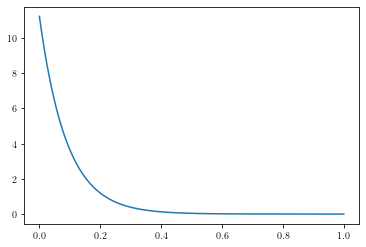

In [40]:
# fit exponential function to the sampled data

import scipy.stats as ss



exp_params = ss.expon.fit(1-cosine_exact_df['similarity'], method='MM')
(e1, e2) = exp_params
exp_params = (0, e2)

print(*exp_params)

exp_x = np.linspace(0, 1, 1000)
exp_pdf_y = ss.expon.pdf(exp_x, *exp_params)


exp_cdf_y = ss.expon.cdf(exp_x, *exp_params)
# plt.plot(exp_x, exp_cdf_y)
plt.plot(exp_x, exp_pdf_y)

check_sum = 0

num_intervals = 10
for i in range(num_intervals):
    start = (1/num_intervals) * i
    end = (1/num_intervals * (i+1))
    prob_on_interval = ss.expon.cdf(end, *exp_params) - ss.expon.cdf(start, *exp_params)
    check_sum += prob_on_interval
    print(f'[{round(start,2)},{round(end,2)}] => {prob_on_interval}, samples: {int(prob_on_interval * random_sample_size)}')

print(check_sum)

In [9]:
(1-cosine_exact_df['similarity']).describe()

count    1000000.000000
mean           0.098857
std            0.089202
min            0.000000
25%            0.032859
50%            0.078028
75%            0.142196
max            0.882273
Name: similarity, dtype: float64

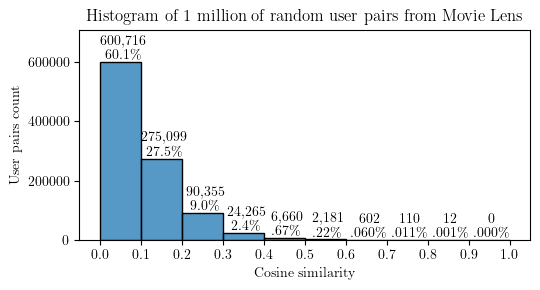

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(5.5, 3), dpi=100)

# data are already grouped by bin, so we can use the same bins
sns.histplot(x=1-cosine_exact_df['similarity'], ax=axs, label='Cosine similarity', bins=10, binwidth=0.1, binrange=(0, 1), color=colors[0])
# ax.bar_label(ax.containers[0])

highest_bar = 0
for i, bar in enumerate(axs.patches):
    bar_height = bar.get_height()
    if bar_height > highest_bar:
        highest_bar = bar_height
    percentage = bar_height / random_sample_size * 100
    format_string = "{0:.1f}"
    if percentage < 1:
        format_string = "{0:.2f}"
    if percentage < 0.1:
        format_string = "{0:.3f}"
    text = format_string.format(bar_height / random_sample_size * 100).lstrip('0')
    text2 = "{:,}".format(int(bar_height))
    # text = str(round(counts_cosine_df_grouped.iloc[i]['count'] / random_sample_size * 100, decimals)) + '%'
    axs.text(bar.get_x() + bar.get_width() / 2 + 0.007, bar.get_height(), text2 + '\n' + text + '\%' , ha='center', va='bottom', rotation=0)
# remove lines around the bars

# sns.lineplot(x=exp_x, y=exp_pdf_y*random_sample_size/10, ax=axs, label='Exponential', color=colors[1])

axs.set_xticks(np.arange(0, 1.1, 0.1))
axs.set_xlabel('Cosine similarity')
axs.set_ylabel('User pairs count')
axs.set_title(f"Histogram of 1 million of random user pairs from Movie Lens")
axs.set_ylim(0, highest_bar * 1.18)
plt.tight_layout()
plt.savefig('../figures/histogram_cosine.pdf')
plt.show()

In [11]:
# # plot histogram
# fig, axs = plt.subplots(1, 1, figsize=(5.5, 3), dpi=100)
# # sns bar plot with wider bins
# # plt.bar(counts_cosine_df_grouped['bin'], counts_cosine_df_grouped['count'], width=0.1, color='#1f77b4')
# # sns.barplot(x='bin', y='count', ax=axs, data=counts_cosine_df_grouped, label='Cosine similarity', color=colors[0])
# # plot histogram from already grouped data
# sns.barplot(x='bin', y='count', ax=axs, data=counts_cosine_df_grouped, label='Cosine similarity', color=colors[0])
# # make bars thinner
# # add text percentage to the bars
# for i, bar in enumerate(axs.patches):
#     bar_height = bar.get_height()
#     percentage = bar_height / random_sample_size * 100
#     format_string = "{0:.1f}"
#     if percentage < 1:
#         format_string = "{0:.2f}"
#     if percentage < 0.1:
#         format_string = "{0:.3f}"
#     text = format_string.format(bar_height / random_sample_size * 100).lstrip('0')
#     text2 = "{:,}".format(int(bar_height))
#     # text = str(round(counts_cosine_df_grouped.iloc[i]['count'] / random_sample_size * 100, decimals)) + '%'
#     axs.text(bar.get_x() + bar.get_width()/2, bar.get_height(), text2 + '\n' + text + '\%' , ha='center', va='bottom', rotation=0)
# # axs.bar_label(axs.containers[0] , padding=2, labels=["{:.0}".format(n/random_sample_size) + '%' for n in counts_cosine_df_grouped['count']])
# axs.set_xlabel('Cosine similarity')
# axs.set_ylabel('User pairs count')
# axs.set_title(f"Histogram of 1 million of random user pairs from Movie Lens")
# highest_bar = counts_cosine_df_grouped.iloc[0]['count']
# axs.set_ylim(0, highest_bar * 1.18)
# plt.tight_layout()
# plt.savefig('../figures/histogram_cosine.pdf')
# plt.show()


In [12]:
# we want to each 0.1 step have 2 times the probability of occurance
def get_assigned_chance(x):
    return 2 ** (x * 10)

# get for each sample the expected probability of occurance from the modeled distribution
def get_modeled_exp_cdf(x, exp_params, number_of_modeled_samples):
    rounded = round(x, 2)
    start = rounded
    end = rounded + 0.01
    prob_on_interval = ss.expon.cdf(end, *exp_params) - ss.expon.cdf(start, *exp_params)
    return prob_on_interval * number_of_modeled_samples



test_df = 1 - cosine_exact_df['similarity'][0:1000]
test_df.sort_values(inplace=True, ascending=False)

print(test_df)

calculated_chance = []
calculated_modeled_prob = []
calculated_ratios = []
similarities = []

progress = tqdm(total=len(test_df))
for similarity in test_df:
    chance = get_assigned_chance(similarity)
    modeled_prob = get_modeled_exp_cdf(similarity, exp_params, random_sample_size)
    ratio = chance / modeled_prob
    calculated_ratios.append(ratio)
    similarities.append(similarity)
    calculated_chance.append(chance)
    calculated_modeled_prob.append(modeled_prob)
    progress.update(1)
progress.close()

# create new dataframe with the calculated ratios and similarity
# test_df['ratio'] = pd.Series(calculated_ratios)
test_df = pd.DataFrame([similarities, calculated_ratios, calculated_modeled_prob, calculated_chance], index=['similarity', 'ratio', 'modeled_prob', 'chance']).T
print(test_df[0:40])


67     0.670693
162    0.566324
890    0.489576
286    0.486871
177    0.484282
         ...   
476    0.000000
475    0.000000
465    0.000000
456    0.000000
395    0.000000
Name: similarity, Length: 1000, dtype: float64


100%|██████████| 1000/1000 [00:00<00:00, 12897.42it/s]

    similarity     ratio  modeled_prob      chance
0     0.670693  0.953236    109.593979  104.468907
1     0.566324  0.168152    301.372841   50.676386
2     0.489576  0.043976    676.952265   29.769506
3     0.486871  0.043159    676.952265   29.216514
4     0.484282  0.038313    749.013745   28.696820
5     0.453928  0.022918   1014.576999   23.252015
6     0.453546  0.022857   1014.576999   23.190466
7     0.443744  0.019301   1122.578588   21.667193
8     0.442704  0.019163   1122.578588   21.511511
9     0.429118  0.015762   1242.076931   19.578196
10    0.427466  0.015583   1242.076931   19.355356
11    0.420480  0.013418   1374.295858   18.440488
12    0.415277  0.012943   1374.295858   17.787191
13    0.404973  0.009843   1682.456022   16.561156
14    0.391020  0.008076   1861.553245   15.034426
15    0.354773  0.004192   2789.988605   11.694245
16    0.353256  0.004148   2789.988605   11.571960
17    0.345949  0.003943   2789.988605   11.000477
18    0.345372  0.003927   2789

In [13]:
# bin the test_df based on similarity and sum the ratio column
test_df_grouped = test_df.groupby(round(test_df['similarity'], 1)).agg({'ratio': 'sum', 'similarity': 'count'})
# rename
test_df_grouped.rename(columns={'ratio': 'total_bin_weight', 'similarity': 'sample_count'}, inplace=True)
# rename index
test_df_grouped.index.names = ['bin']
test_df_grouped

,total_bin_weight,sample_count
bin,,
0.0,0.005014,338
0.1,0.025776,426
0.2,0.047846,171
0.3,0.074300,48
0.4,0.122429,10
0.5,0.171223,5
0.6,0.168152,1
0.7,0.953236,1
